In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os
import io, zipfile, requests
import statsmodels.api as sm

sector_assets = ["XLB","XLE","XLF","XLI","XLK","XLP","XLU","XLV","XLY"]
tickers = sector_assets + ["SPY"]

TOP_N = 3
COST_BPS = 10
START = "1999-01-01"

In [2]:
prices = yf.download(tickers, start=START, auto_adjust=True)["Close"]
month_end = prices.resample("ME").last()
monthly_ret = month_end.pct_change()

print("Month-end:", month_end.index.min(), "→", month_end.index.max(), "| cols:", month_end.shape[1])

[*********************100%***********************]  10 of 10 completed


Month-end: 1999-01-31 00:00:00 → 2026-01-31 00:00:00 | cols: 10


In [3]:
mom_12_1 = (month_end[sector_assets] / month_end[sector_assets].shift(12) - 1).shift(1)
mom_12_1 = mom_12_1.dropna()

ranks = mom_12_1.rank(axis=1, ascending=False)
weights = (ranks <= TOP_N).astype(int)
weights = weights.div(weights.sum(axis=1), axis=0)

In [ ]:
ret_assets = monthly_ret.loc[mom_12_1.index, sector_assets]
spy_ret = monthly_ret.loc[mom_12_1.index, "SPY"]

port_gross = (weights * ret_assets).sum(axis=1).dropna()
spy_ret = spy_ret.loc[port_gross.index]

turnover = weights.loc[port_gross.index].diff().abs().sum(axis=1) / 2
port_net = port_gross - turnover * (COST_BPS / 10000)

print("Months:", len(port_net), "| Avg turnover:", float(turnover.mean()))

Months: 312 | Avg turnover: 0.22222222222222215


In [ ]:
VOL_TARGET = 0.20
VOL_LOOKBACK = 12
LEVERAGE_CAP = 1.0  # de-risk only

roll_vol = port_net.rolling(VOL_LOOKBACK).std() * np.sqrt(12)
scale = (VOL_TARGET / roll_vol).shift(1).clip(upper=LEVERAGE_CAP)

port_net_voltarget = (port_net * scale).dropna()

print("VolTarget avg scale:", float(scale.dropna().mean()))
print("Ann vol (base):", float(port_net.dropna().std() * np.sqrt(12)))
print("Ann vol (voltarget):", float(port_net_voltarget.dropna().std() * np.sqrt(12)))

VolTarget avg scale: 0.9831935449685221
Ann vol (base): 0.15068124698838642
Ann vol (voltarget): 0.14356105100833808


In [6]:
strategy_ret = port_net_voltarget

In [7]:
def cagr(r):
    n_years = len(r)/12
    return (1+r).prod()**(1/n_years)-1 if n_years>0 else np.nan

def ann_vol(r): return r.std()*np.sqrt(12)
def sharpe0(r): return r.mean()/r.std()*np.sqrt(12)
def max_dd(r):
    eq = (1+r).cumprod()
    peak = eq.cummax()
    return (eq/peak - 1).min()

def slice_period(s, start, end):
    return s.loc[(s.index >= start) & (s.index <= end)]

periods = {
    "Full (1999–2026)": ("1999-01-01", "2026-12-31"),
    "Lost Decade (2000–2010)": ("2000-01-01", "2010-12-31"),
    "Post-GFC Bull (2011–2026)": ("2011-01-01", "2026-12-31"),
}

rows=[]
for name,(a,b) in periods.items():
    rS = slice_period(strategy_ret,a,b).dropna()
    rB = slice_period(spy_ret,a,b).dropna()
    ix = rS.index.intersection(rB.index)
    rS, rB = rS.loc[ix], rB.loc[ix]
    rows.append({
        "Period": name,
        "Months": len(ix),
        "CAGR (Strat)": cagr(rS),
        "CAGR (SPY)": cagr(rB),
        "Sharpe (rf=0)": sharpe0(rS),
        "Sharpe SPY (rf=0)": sharpe0(rB),
        "MaxDD (Strat)": max_dd(rS),
        "MaxDD (SPY)": max_dd(rB),
        "Ann.Vol (Strat)": ann_vol(rS),
        "Ann.Vol (SPY)": ann_vol(rB),
        "Avg Turnover": float(turnover.loc[ix].mean()) if len(ix)>0 else np.nan
    })

pd.DataFrame(rows)

,Period,Months,CAGR (Strat),CAGR (SPY),Sharpe (rf=0),Sharpe SPY (rf=0),MaxDD (Strat),MaxDD (SPY),Ann.Vol (Strat),Ann.Vol (SPY),Avg Turnover
0,Full (1999–2026),301,0.087961,0.088087,0.661801,0.639162,-0.400176,-0.507848,0.143561,0.150367,0.224806
1,Lost Decade (2000–2010),120,0.044915,0.014246,0.362835,0.169255,-0.400176,-0.507848,0.154651,0.163569,0.241667
2,Post-GFC Bull (2011–2026),181,0.117472,0.139983,0.890568,1.011470,-0.248563,-0.239272,0.135640,0.139868,0.213628


In [8]:
import pandas as pd
import statsmodels.api as sm
import requests
import zipfile
import io
import re

# 1. Robust Fama-French Loader (Fixes the "Footer Text" Crash)
def load_ff_robust(url):
    r = requests.get(url)
    r.raise_for_status()
    z = zipfile.ZipFile(io.BytesIO(r.content))
    fname = z.namelist()[0]
    raw = z.read(fname).decode("utf-8", errors="ignore").splitlines()
    
    # Find start of data (row starting with a date like 192701)
    start_idx = next(i for i, line in enumerate(raw) if re.match(r"^\s*\d{6}", line))
    
    # Read until the next blank line (skips footer text)
    data_lines = []
    for line in raw[start_idx:]:
        if not line.strip(): break # Stop at empty line
        data_lines.append(line)
        
    # Parse
    df = pd.read_csv(io.StringIO("\n".join(data_lines)), sep=",", header=None, index_col=0)
    
    # Clean Index
    df.index.name = "Date"
    df.index = pd.to_datetime(df.index.astype(str), format="%Y%m") + pd.offsets.MonthEnd(0)
    
    # Convert percentages to decimals
    return df.astype(float) / 100

print("Downloading Factor Data...")
# Load 5-Factor (We will only use Mkt, HML)
ff5_raw = load_ff_robust("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip")
ff5_raw.columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]

# Load Momentum
mom_raw = load_ff_robust("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip")
mom_raw.columns = ["MOM"]

# Merge
factors = pd.concat([ff5_raw, mom_raw], axis=1).dropna()

# 2. Run Attribution Regression
# FIX: Align with Vol-Targeted Strategy (port_net_voltarget) for consistency
common = port_net_voltarget.index.intersection(factors.index)
y = port_net_voltarget.loc[common] - factors.loc[common, "RF"]

# FIX: Drop SMB (Size) and others. Keep only Sector-relevant factors.
# Sector Rotation is primarily Market Beta, Value (HML) shifts, and Momentum.
X = factors.loc[common, ["Mkt-RF", "HML", "MOM"]]
X = sm.add_constant(X)

print("\nRunning Regression on Risk-Managed Returns...")
model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

print(model.summary())


Running Regression on Risk-Managed Returns...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     205.3
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           5.40e-72
Time:                        06:37:38   Log-Likelihood:                 779.30
No. Observations:                 300   AIC:                            -1551.
Df Residuals:                     296   BIC:                            -1536.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

C:\Users\cobyb\AppData\Local\Temp\ipykernel_11220\3507654541.py:45: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  factors = pd.concat([ff5_raw, mom_raw], axis=1).dropna()


In [9]:
import re
import pandas as pd
import io, zipfile, requests

def load_kf_mom_monthly():
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
    r = requests.get(url)
    r.raise_for_status()

    z = zipfile.ZipFile(io.BytesIO(r.content))
    fname = z.namelist()[0]
    raw = z.read(fname).decode("utf-8", errors="ignore").splitlines()

    # Find first data row like "192701,  0.12" (YYYYMM at start)
    start = next(i for i, line in enumerate(raw) if re.match(r"^\s*\d{6}", line.strip()))
    tail = raw[start:]

    # Stop at first blank line after the table
    end_rel = next(i for i, line in enumerate(tail) if line.strip() == "")
    table = "\n".join(tail[:end_rel])

    df = pd.read_csv(io.StringIO(table), header=None)
    df = df.iloc[:, :2]
    df.columns = ["YYYYMM", "MOM"]

    idx = pd.to_datetime(df["YYYYMM"].astype(int).astype(str), format="%Y%m") + pd.offsets.MonthEnd(0)
    df.index = idx

    # percent -> decimal
    mom = df["MOM"].astype(float) / 100.0
    return mom

mom = load_kf_mom_monthly().to_frame("MOM")
print("MOM months:", mom.index.min(), "→", mom.index.max())
mom.head()

MOM months: 1927-01-31 00:00:00 → 2025-12-31 00:00:00


,MOM
YYYYMM,
1927-01-31,0.0057
1927-02-28,-0.0150
1927-03-31,0.0352
1927-04-30,0.0436
1927-05-31,0.0278


In [10]:
rS = strategy_ret.loc["2000-01-01":"2010-12-31"].dropna()
rB = spy_ret.loc["2000-01-01":"2010-12-31"].dropna()
ix = rS.index.intersection(rB.index)
rS, rB = rS.loc[ix], rB.loc[ix]

wealth_S = (1+rS).prod()
wealth_B = (1+rB).prod()
ratio = wealth_S / wealth_B

wealth_S, wealth_B, ratio

(np.float64(1.5517040229571584),
 np.float64(1.151945543830363),
 np.float64(1.3470289730863045))

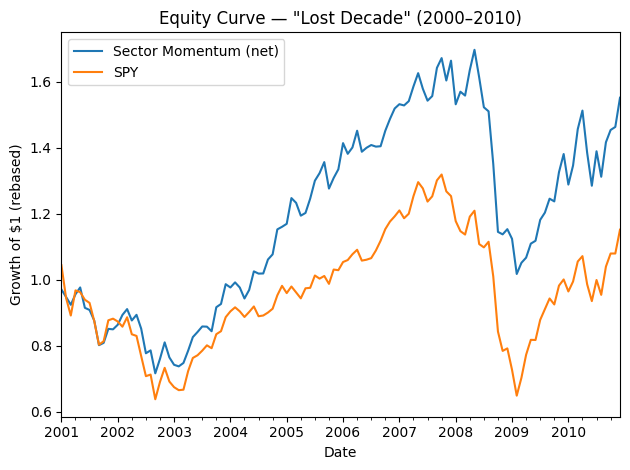

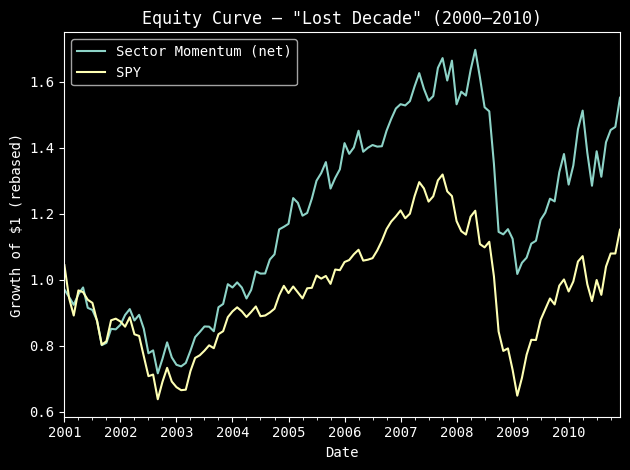

In [11]:
import matplotlib.pyplot as plt
import os

os.makedirs("figures/light", exist_ok=True)
os.makedirs("figures/dark", exist_ok=True)

def plot_equity(start, end, title, fname):
    rS = strategy_ret.loc[start:end].dropna()
    rB = spy_ret.loc[start:end].dropna()
    ix = rS.index.intersection(rB.index)
    rS, rB = rS.loc[ix], rB.loc[ix]

    eqS = (1+rS).cumprod()
    eqB = (1+rB).cumprod()

    # light
    plt.figure()
    eqS.plot(label="Sector Momentum (net)")
    eqB.plot(label="SPY")
    plt.title(title)
    plt.ylabel("Growth of $1 (rebased)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/light/{fname}.png")
    plt.show()

    # dark
    with plt.style.context("dark_background"):
        plt.rcParams["font.family"] = "monospace"
        plt.figure()
        eqS.plot(label="Sector Momentum (net)")
        eqB.plot(label="SPY")
        plt.title(title)
        plt.ylabel("Growth of $1 (rebased)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"figures/dark/{fname}.png", facecolor="black", edgecolor="none")
        plt.show()

plot_equity("2000-01-01","2010-12-31",'Equity Curve — "Lost Decade" (2000–2010)',"moneyshot_lost_decade")